In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('wowah_data.csv')

In [3]:
df.head()

,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   char        int64 
 1    level      int64 
 2    race       object
 3    charclass  object
 4    zone       object
 5    guild      int64 
 6    timestamp  object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


In [5]:
## 전처리

In [6]:
# 컬럼명에 있는 공백 제거
for col in df.columns:
    df = df.rename(columns={col:col.strip()})

In [7]:
# timestamp 컬럼 datetime 유형으로 변경
df['time'] = pd.to_datetime(df['timestamp'])

In [8]:
df = df.rename(columns={'time':'datetime'})

In [9]:
df['year'] = df['datetime'].dt.year  
df['month'] = df['datetime'].dt.month  

In [10]:
df['date'] = df['datetime'].dt.date  
df['time'] = df['datetime'].dt.time  

In [11]:
df = df.sort_values(by=['char', 'datetime']).reset_index(drop=True)
df['datetime_lag'] = df.groupby(by=['char'])['datetime'].shift(1) # 유저별로 이전 쿼리 시간 가져오기
df['time_diff_lag'] = df['datetime'] - df['datetime_lag'] # 이전 쿼리와의 시간 차 계산
first_play_time_idx = df[df.time_diff_lag.isna()].index  # 유저별 최초 접속 시간 행의 인덱스
first_session_time_idx = df[df['time_diff_lag'] > timedelta(minutes = 30)].index  # 유저별 세션 시작 시간 행의 인덱스

In [12]:
df['session_status'] = 9999

df.loc[first_session_time_idx, 'session_status'] = 1  # 세션이 시작된 시간
df.loc[(first_session_time_idx - 1), 'session_status'] = 2  # 세션이 끝난 시간
df.loc[first_play_time_idx, 'session_status'] = 1  # 유저별 최초 접속 시간

In [13]:
df = df.sort_values(by=['char', 'datetime'], ascending=False).reset_index(drop=True)
df['datetime_lead'] = df.groupby(by=['char'])['datetime'].shift(1) # 유저별로 다음 쿼리 시간 가져오기
df['time_diff_lead'] = df['datetime'] - df['datetime_lead'] # 다음 쿼리와의 시간 차 계산
last_play_time_idx = df[df.time_diff_lead.isna()].index  # 유저별 최종 접속 시간 행의 인덱스

df.loc[last_play_time_idx, 'session_status'] = 2  # 유저별 최종 접속 시간

In [14]:
df_session = df[(df.session_status==1) | (df.session_status==2)]  # 시간 및 끝난 시간만 저장

In [15]:
df_session = df_session.sort_values(by=['char', 'datetime']).reset_index(drop=True)

In [16]:
del df_session['time_diff_lead']

In [17]:
df_session.head()

,char,level,race,charclass,zone,guild,timestamp,datetime,year,month,date,time,datetime_lag,time_diff_lag,session_status,datetime_lead
0,2,18,Orc,Shaman,The Barrens,6,12/03/08 10:41:47,2008-12-03 10:41:47,2008,12,2008-12-03,10:41:47,NaT,NaT,2,NaT
1,7,54,Orc,Hunter,Feralas,-1,01/15/08 21:47:09,2008-01-15 21:47:09,2008,1,2008-01-15,21:47:09,NaT,NaT,1,2008-01-15 21:56:54
2,7,55,Orc,Hunter,Orgrimmar,282,01/16/08 00:26:56,2008-01-16 00:26:56,2008,1,2008-01-16,00:26:56,2008-01-16 00:17:12,0 days 00:09:44,2,2008-01-16 21:57:02
3,7,55,Orc,Hunter,Orgrimmar,282,01/16/08 21:57:02,2008-01-16 21:57:02,2008,1,2008-01-16,21:57:02,2008-01-16 00:26:56,0 days 21:30:06,1,2008-01-16 22:07:09
4,7,55,Orc,Hunter,Orgrimmar,282,01/17/08 01:16:49,2008-01-17 01:16:49,2008,1,2008-01-17,01:16:49,2008-01-17 01:07:06,0 days 00:09:43,2,2008-01-17 18:47:07


In [18]:
df_session['datetime_lag'] = df_session.groupby(by=['char'])['datetime'].shift(1) # 세션이 시작된 시간(이전 행 값)을 세션이 끝난 시간과 동일한 행에 배치

In [19]:
df_session['time_diff'] = df_session['datetime'] - df_session['datetime_lag']  # 세션별 게임 플레이 시간 계산

In [21]:
session_start = df_session[df_session.session_status==1][[ 'char', 'level', 'race', 'charclass', 'zone', 'guild', 'timestamp', 'datetime']]
session_end = df_session[df_session.session_status==2][[ 'char', 'level', 'race', 'charclass', 'zone', 'guild', 'timestamp', 'datetime', 'time_diff']]

session_start = session_start.rename(columns={'datetime':'session_start'})
session_end = session_end.rename(columns={'datetime':'session_end', 'time_diff':'playtime'})

In [22]:
session_end['date'] = session_end['session_end'].dt.date  
session_end.reset_index(drop=True, inplace=True)
session_end['playtime_hours'] = [time.total_seconds()/3600 for time in session_end.playtime]

In [23]:
session_end.head()

,char,level,race,charclass,zone,guild,timestamp,session_end,playtime,date,playtime_hours
0,2,18,Orc,Shaman,The Barrens,6,12/03/08 10:41:47,2008-12-03 10:41:47,NaT,2008-12-03,NaN
1,7,55,Orc,Hunter,Orgrimmar,282,01/16/08 00:26:56,2008-01-16 00:26:56,0 days 02:39:47,2008-01-16,2.663056
2,7,55,Orc,Hunter,Orgrimmar,282,01/17/08 01:16:49,2008-01-17 01:16:49,0 days 03:19:47,2008-01-17,3.329722
3,7,56,Orc,Hunter,Undercity,282,01/18/08 00:07:32,2008-01-18 00:07:32,0 days 05:20:25,2008-01-18,5.340278
4,7,56,Orc,Hunter,Undercity,282,01/19/08 01:47:16,2008-01-19 01:47:16,0 days 02:30:03,2008-01-19,2.500833


In [24]:
mt_24 = session_end[session_end.playtime_hours>24].index
session_end_mt24 = session_end.loc[mt_24]

In [25]:
session_end_mt24.playtime = session_end_mt24.playtime.dt.round('12h')  # 12시간 단위로 일(day) 반올림
session_end_mt24['playtime_days'] = [time.days for time in session_end_mt24.playtime]
session_end_mt24['playtime_per_day'] = session_end_mt24['playtime_hours'] / session_end_mt24['playtime_days'] 

In [26]:
del session_end_mt24['playtime_days']
del session_end_mt24['playtime_hours']
session_end_mt24 = session_end_mt24.rename(columns={'playtime_per_day':'playtime_hours'})

In [27]:
lt_24 = session_end[session_end.playtime_hours<24].index
session_end_lt_24 = session_end.loc[lt_24]

In [28]:
session_end_re = pd.concat([session_end_lt_24, session_end_mt24])

In [29]:
playtime_daily_per_user = session_end_re.groupby(by=['date', 'char']).playtime_hours.sum().reset_index()  # 날짜 및 유저별 플레이 시간

In [30]:
daily_average_playtime = playtime_daily_per_user.groupby('date').playtime_hours.mean().reset_index() # 날짜별 유저당 평균 플레이 시간

In [31]:
daily_average_playtime.playtime_hours.describe()

count    352.000000
mean       8.119055
std        0.823007
min        4.091214
25%        7.731636
50%        8.150971
75%        8.589386
max       10.617245
Name: playtime_hours, dtype: float64

<AxesSubplot:xlabel='date', ylabel='playtime_hours'>

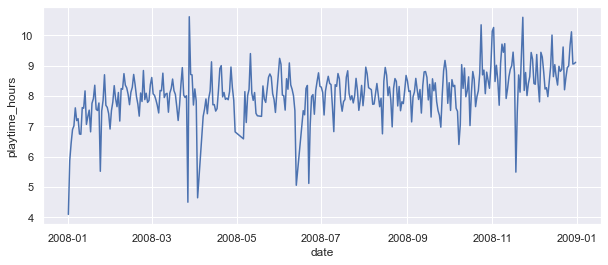

In [32]:
#daily average play time per users
plt.figure(figsize = (10,4))
sns.set(style='darkgrid')
sns.lineplot(x='date', y='playtime_hours', data=daily_average_playtime) 

In [33]:
daily_median_playtime = playtime_daily_per_user.groupby('date').playtime_hours.median().reset_index() # 날짜별 유저당 평균 플레이 시간

In [34]:
daily_median_playtime.playtime_hours.describe()

count    352.000000
mean       3.729820
std        0.783731
min        1.668056
25%        3.189375
50%        3.648264
75%        4.180903
max        6.670000
Name: playtime_hours, dtype: float64

<AxesSubplot:xlabel='date', ylabel='playtime_hours'>

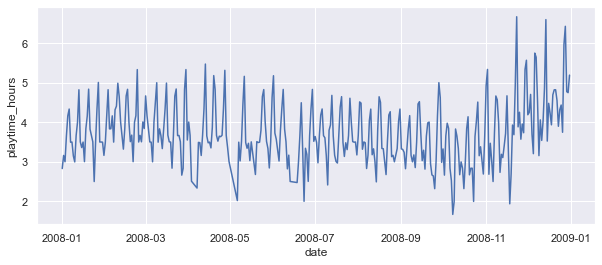

In [35]:
#daily median play time per users
plt.figure(figsize = (10,4))
sns.set(style='darkgrid')
sns.lineplot(x='date', y='playtime_hours', data=daily_median_playtime) 

In [36]:
#dau
dau = pd.DataFrame(df.groupby('date').char.nunique()).reset_index()

In [37]:
#mau
mau = pd.DataFrame(df.groupby(by=['year','month']).char.nunique()).reset_index()

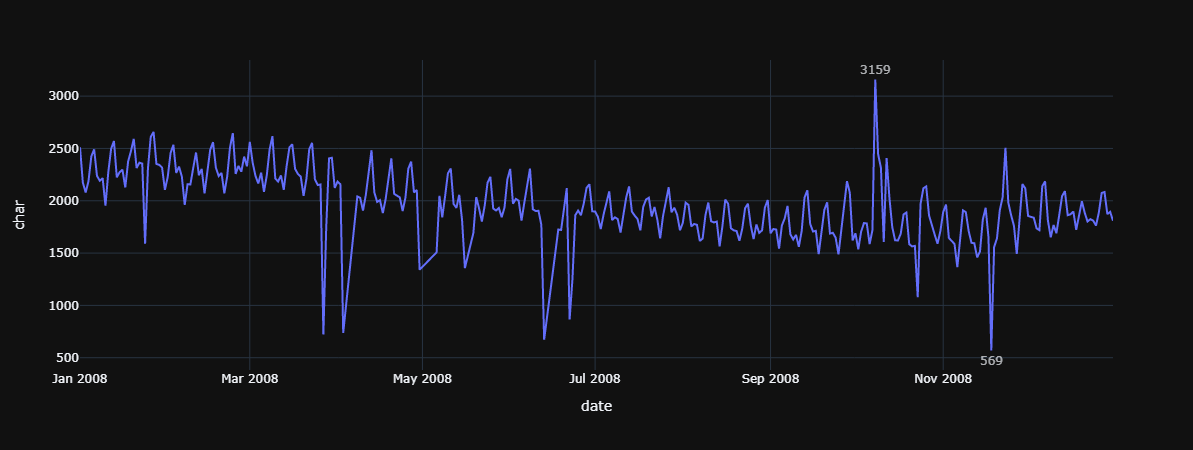

<Figure size 720x288 with 0 Axes>

In [53]:
plt.figure(figsize = (10,4))
fig = px.line(dau, x='date', y='char', template='plotly_dark')
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=dau.date[dau.max(axis = 1).idxmax()],
                   y=dau.max().char,
                   text=str(dau.max().char),
                   yshift=10,
                   opacity=0.7)
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=dau.date[dau.min(axis = 1).idxmin()],
                   y=dau.min().char,
                   text=str(dau.min().char),
                   yshift=-10,
                   opacity=0.7)
fig.show()
fig.write_image("img/dau.png")

In [39]:
for i in range(len(mau)):
    mau.loc[i, 'time'] = str(mau.loc[i, 'year']) + '-' + str(mau.loc[i, 'month'])

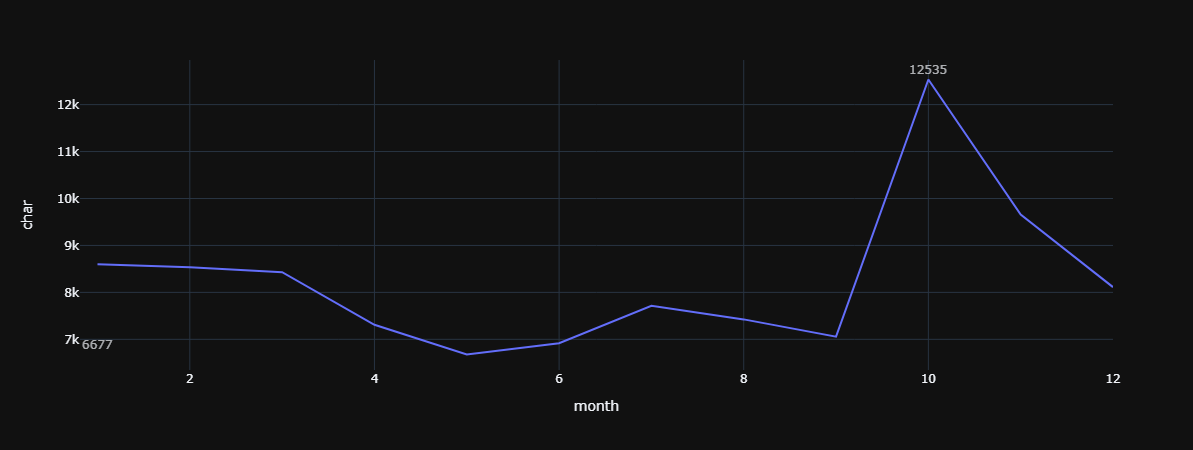

In [52]:
fig = px.line(mau, x='month', y='char', template='plotly_dark')
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=mau.month[mau.max(axis = 1).idxmax()],
                   y=mau.max().char,
                   text=str(mau.max().char),
                   yshift=10,
                   opacity=0.7)
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=mau.month[mau.min(axis = 1).idxmin()],
                   y=mau.min().char,
                   text=str(mau.min().char),
                   yshift=10,
                   opacity=0.7)
fig.show()
fig.write_image("img/mau.png")

In [236]:
# retention rate

In [41]:
#유저별로 첫번째 접속한 날짜
first_login = df.groupby(by=['char'])['date'].min().reset_index()

In [42]:
first_login = first_login.rename(columns={'date':'first_date'})

In [43]:
df_merged = pd.merge(df, first_login, how='left', on='char')

In [44]:
df_merged['day_played'] = df_merged['date'] - df_merged['first_date']

In [45]:
cohort_played = pd.pivot_table(df_merged, index=['first_date'], columns =['day_played'], values='char', aggfunc=pd.Series.nunique)

In [46]:
retention = []
for col in cohort_played.columns:
    retention_i = cohort_played[col].fillna(0).sum() / (cohort_played[col].fillna(0).astype('bool').astype('int') * cohort_played['0 days']).sum()
    retention.append(retention_i)

In [48]:
retention_df = pd.DataFrame({'cohort':cohort_played.columns[1:], 'retention':retention[1:]})

In [49]:
retention_df['retention'] = [round(x, 2) for x in retention_df['retention']]

In [50]:
retention_df['cohort'] = [str(dt.days) + ' days' for dt in retention_df['cohort'] ]

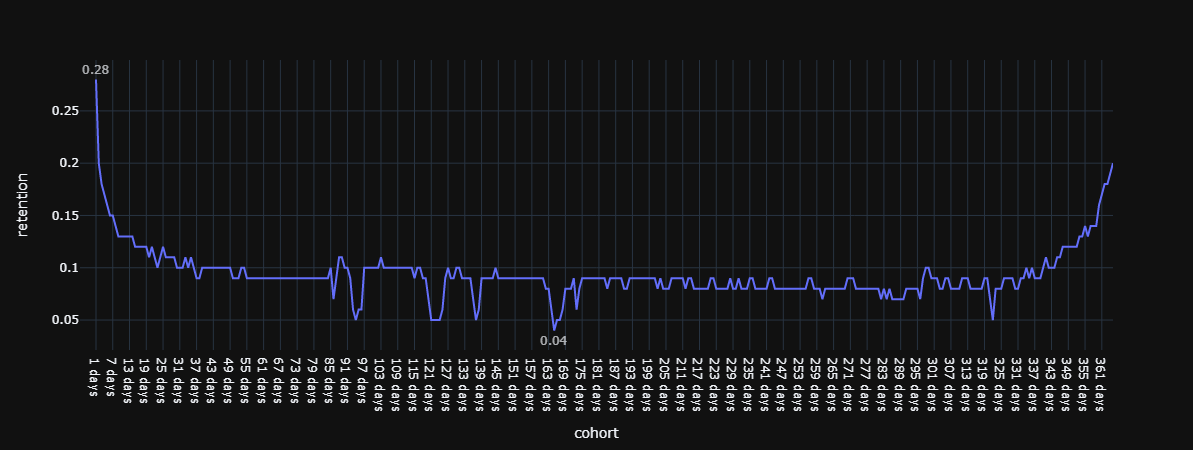

In [54]:
fig = px.line(retention_df, x='cohort', y='retention', template='plotly_dark')
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=retention_df.cohort[retention_df.max(axis = 1).idxmax()],
                   y=retention_df.max().retention,
                   text=str(retention_df.max().retention),
                   yshift=10,
                   opacity=0.7)
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=retention_df.cohort[retention_df.min(axis = 1).idxmin()],
                   y=retention_df.min().retention,
                   text=str(retention_df.min().retention),
                   yshift=-10,
                   opacity=0.7)
fig.show()
fig.write_image("img/retention.png")